## Importing the required Libraries

In [2]:
import math
import random
from PIL import Image, ImageDraw, ImageFont

In [3]:
try:
    from scipy.spatial import cKDTree as KDTree
    import numpy as np
    IMPORTED_SCIPY = True
except ImportError:
    IMPORTED_SCIPY = False

## Defining the colors of the dots and number of dots

In [4]:
 BACKGROUND = (255, 255, 255)
TOTAL_CIRCLES = 1500

color = lambda c: ((c >> 16) & 255, (c >> 8) & 255, c & 255)

COLORS_ON = [
    color(0x9CA594), color(0xACB4A5), color(0xBBB964),
    color(0xD7DAAA), color(0xE5D57D), color(0xD1D6AF)
]
COLORS_OFF = [
    color(0xF9BB82), color(0xEBA170), color(0xFCCD84)
]


## This function generates an image with the specified text at the center.
text: The text to be drawn on the image.
font_path: The file path to the font.
font_size: The font size.
image_size: The size of the image in pixels (width, height).
It creates a new RGB image with the given dimensions and background color. Then, it initializes an ImageDraw object to draw on this image. Next, it loads the specified TrueType font using ImageFont.truetype. It calculates the width and height of the text using the specified font. Finally, it positions the text at the center of the image and draws the text on the image using the specified font and fill color. The resulting image with the text is then returned.

In [5]:
def generate_image_with_text(text, font_path, font_size, image_size):
    image = Image.new('RGB', image_size, BACKGROUND)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, font_size)
    text_width, text_height = draw.textsize(text, font=font)
    text_position = ((image_size[0] - text_width) // 2, (image_size[1] - text_height) // 2)
    draw.text(text_position, text, fill=(0, 0, 0), font=font)
    return image

## This function generates a random circle within the specified bounds.

image_width: The width of the image where the circle will be placed.
image_height: The height of the image where the circle will be placed.
min_diameter: The minimum diameter of the circle.
max_diameter: The maximum diameter of the circle.

In [6]:
def generate_circle(image_width, image_height, min_diameter, max_diameter):
    radius = random.triangular(min_diameter, max_diameter,
                               max_diameter * 0.8 + min_diameter * 0.2) / 2

    angle = random.uniform(0, math.pi * 2)
    distance_from_center = random.uniform(0, min(image_width, image_height) * 0.48 - radius)
    x = image_width  * 0.5 + math.cos(angle) * distance_from_center
    y = image_height * 0.5 + math.sin(angle) * distance_from_center

    return x, y, radius

## This function checks if a circle overlaps with any non-background pixel in the given image.

image: The input image where the circle is to be drawn.
circle: A tuple containing the (x, y, r) coordinates and radius of the circle to be checked for overlap.

In [7]:
def overlaps_motive(image, circle):
    x, y, r = circle
    points_x = [x, x, x, x-r, x+r, x-r*0.93, x-r*0.93, x+r*0.93, x+r*0.93]
    points_y = [y, y-r, y+r, y, y, y+r*0.93, y-r*0.93, y+r*0.93, y-r*0.93]

    for xy in zip(points_x, points_y):
        if image.getpixel(xy)[:3] != BACKGROUND:
            return True

    return False

## This function checks if two circles intersect with each other.

circle1 and circle2: Tuples containing the (x, y, r) coordinates and radius of the circles to be checked for intersection.

In [8]:
def circle_intersection(circle1, circle2):
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2
    return (x2 - x1)**2 + (y2 - y1)**2 < (r2 + r1)**2

## This function draws a circle on an image.

draw_image: The ImageDraw object to draw on.
image: The original image on which the circle will be drawn.
circle: A tuple containing the (x, y, r) coordinates and radius of the circle to be drawn.

In [10]:
def circle_draw(draw_image, image, circle):
    fill_colors = COLORS_ON if overlaps_motive(image, circle) else COLORS_OFF
    fill_color = random.choice(fill_colors)

    x, y, r = circle
    draw_image.ellipse((x - r, y - r, x + r, y + r),
                       fill=fill_color,
                       outline=fill_color)

## The main() function orchestrates the generation of the image with text and circles based on user input.

In [11]:
def main():
    text = input("Enter text or number to be drawn: ")
    font_path = "arial.ttf"
    font_size = 300
    image_size = (500, 500)  
    input_image = generate_image_with_text(text, font_path, font_size, image_size)

    image2 = Image.new('RGB', input_image.size, BACKGROUND)
    draw_image = ImageDraw.Draw(image2)

    width, height = input_image.size
    min_diameter = (width + height) / 200
    max_diameter = (width + height) / 75

    circle = generate_circle(width, height, min_diameter, max_diameter)
    circles = [circle]

    circle_draw(draw_image, input_image, circle)

    try:
        for i in range(TOTAL_CIRCLES):
            tries = 0
            if IMPORTED_SCIPY:
                kdtree = KDTree([(x, y) for (x, y, _) in circles])
                while True:
                    circle = generate_circle(width, height, min_diameter, max_diameter)
                    elements, indexes = kdtree.query([(circle[0], circle[1])], k=12)
                    for element, index in zip(elements[0], indexes[0]):
                        if not np.isinf(element) and circle_intersection(circle, circles[index]):
                            break
                    else:
                        break
                    tries += 1
            else:
                while any(circle_intersection(circle, circle2) for circle2 in circles):
                    tries += 1
                    circle = generate_circle(width, height, min_diameter, max_diameter)

            print('{}/{} {}'.format(i, TOTAL_CIRCLES, tries))

            circles.append(circle)
            circle_draw(draw_image, input_image, circle)
    except (KeyboardInterrupt, SystemExit):
        pass

    image2.show()

if __name__ == '__main__':
    main()


Enter text or number to be drawn: 3


C:\Users\print\AppData\Local\Temp\ipykernel_29344\624053219.py:5: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0/1500 0
1/1500 0
2/1500 0
3/1500 0
4/1500 0
5/1500 0
6/1500 0
7/1500 0
8/1500 0
9/1500 0
10/1500 0
11/1500 0
12/1500 0
13/1500 0
14/1500 0
15/1500 0
16/1500 0
17/1500 0
18/1500 0
19/1500 0
20/1500 0
21/1500 0
22/1500 0
23/1500 0
24/1500 0
25/1500 0
26/1500 0
27/1500 0
28/1500 0
29/1500 0
30/1500 0
31/1500 0
32/1500 0
33/1500 0
34/1500 0
35/1500 0
36/1500 0
37/1500 1
38/1500 0
39/1500 0
40/1500 0
41/1500 1
42/1500 0
43/1500 0
44/1500 1
45/1500 0
46/1500 0
47/1500 0
48/1500 1
49/1500 0
50/1500 0
51/1500 0
52/1500 1
53/1500 0
54/1500 1
55/1500 0
56/1500 0
57/1500 0
58/1500 2
59/1500 1
60/1500 0
61/1500 0
62/1500 0
63/1500 0
64/1500 0
65/1500 0
66/1500 0
67/1500 0
68/1500 1
69/1500 0
70/1500 0
71/1500 0
72/1500 0
73/1500 0
74/1500 0
75/1500 0
76/1500 0
77/1500 0
78/1500 0
79/1500 0
80/1500 0
81/1500 0
82/1500 0
83/1500 0
84/1500 0
85/1500 0
86/1500 0
87/1500 0
88/1500 0
89/1500 1
90/1500 1
91/1500 0
92/1500 1
93/1500 0
94/1500 0
95/1500 0
96/1500 0
97/1500 3
98/1500 1
99/1500 0
100/1500 0

## outputimage

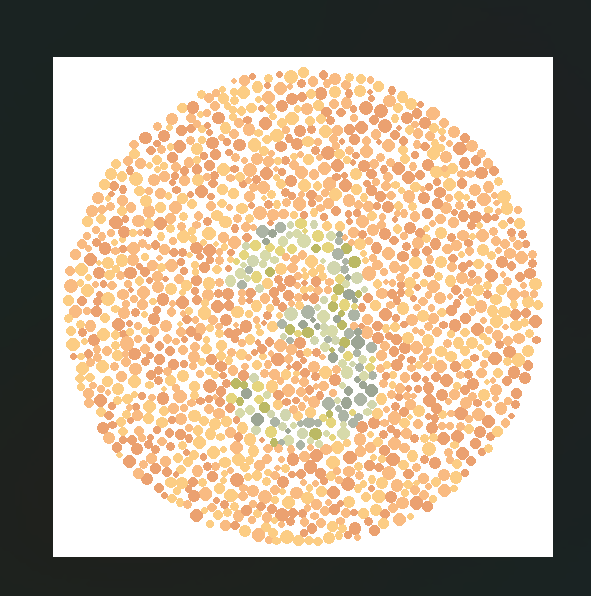

In [12]:
from PIL import Image
from IPython.display import display

# Open the image file
image = Image.open("D:\harish\output.png") 

# Display the image
display(image)
